In [1]:
#load mask and trackmate puncta
## test whether puncta are on mask
## calculate percentage and correct for extra fluorescence on ridges

In [1]:
#fancy jupyter lab gimmicks
%load_ext autoreload
%autoreload 2
# put plots in between cells
%matplotlib inline
# enable widgets from terminal (specified by !)
!jupyter nbextension enable --py widgetsnbextension

#import libraries
import pandas as pd
import os # folder and their item navigation and bookkeeping
import matplotlib.pyplot as plt # all things plotting
import sys # allows us to cue the notebook to look for external Python scripts 
from ipywidgets import interact, interactive, fixed, interact_manual # for interactive widgets
import ipywidgets as widgets
import itk # for image (tiff) loading
import numpy as np # manipulating array-like structures
import pickle # for saving data structures
import cv2
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset # for plot decoration
# allow lots of figures
plt.rcParams.update({'figure.max_open_warning': 0})
# the Python scripts added to the local path
sys.path.append(os.path.abspath(os.getcwd()+'/cmeAnalysisPostProcessingPythonScripts/'))
source_code = os.getcwd()+'/cmeAnalysisPostProcessingPythonScripts/'

# custom Python scripts for this analysis
from display_tracks import load_tracks
from nanopillar_detection import (hough_detection, 
                                  createLineIterator, 
                                  create_mask_from_hough_lines, 
                                  load_itk_image,
                                  test_on_pillar,
                                  format_image_hough_detection,
                                  return_puncta_relative_to_pillar,
                                  modify_filename)
from display_tracks import (load_tracks, load_tracks_no_sort, display_tracks,
                            remove_tracks_by_criteria, 
                            select_tracks_by_indices,
                            remove_tracks_by_indices, 
                            load_itk_image)

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
from skimage import feature, exposure, io
from skimage.color import rgb2gray
from skimage.filters import median
from skimage.morphology import disk


The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.


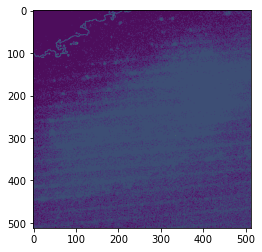

In [597]:

all_cell_mask_cell_pixel_fraction = []
mask_sample = '/Volumes/Backup Plus/CK666 trials/50uM/75nm/cell1_2s/trackmate/GFP/MDA_dnm2GFP_AP2RFP_substr_20uMCK666_post_002.nd2 - C=1.tif kept stack.tif' 
raw_image = io.imread(mask_sample)
grayscale_image = rgb2gray(raw_image)
grayscale_image=median(grayscale_image,disk(8))
percentile_threshold = np.percentile(grayscale_image.flatten(),4)
edges = feature.canny(grayscale_image>percentile_threshold, sigma=1)
plt.imshow(grayscale_image>percentile_threshold,alpha=0.08)
plt.imshow(exposure.adjust_gamma(raw_image, 0.00001),alpha=0.9)
plt.imshow(edges,alpha=0.5)
#plt.imshow(imagecodecs.imread(all_cell_masks[i]),alpha=0.2)
plt.show()
all_cell_mask_cell_pixel_fraction.append((grayscale_image>percentile_threshold).sum()/(512*512))
cell_mask = grayscale_image>percentile_threshold

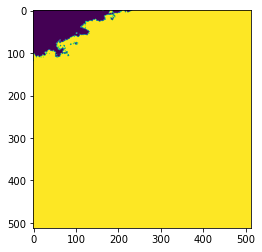

In [598]:
plt.imshow(grayscale_image>percentile_threshold,alpha=1)

In [599]:

cell_mask = grayscale_image>percentile_threshold


In [615]:
# Import your files! Fl channel, BF channel, puncta csv, processed tracks

fl_image = '/Volumes/Backup Plus/CK666 trials/50uM/75nm/cell1_2s/trackmate/RFP/MDA_dnm2GFP_AP2RFP_substr_20uMCK666_post_002.nd2 - C=2.tif kept stack.tif'        
bf_image = '/Volumes/Backup Plus/CK666 trials/50uM/75nm/cell1_2s/MDA_dnm2GFP_AP2RFP_substr_20uMCK666_post_002.nd2 - C=0 kept stack.tif'
puncta_csv = pd.read_csv('/Volumes/Backup Plus/CK666 trials/50uM/75nm/cell1_2s/trackmate/RFP/All Spots statistics.csv')

#import mask
mask_for_templates = np.load('/Volumes/Backup Plus/CK666 trials/50uM/75nm/cell1_2s/mask_MDA_dnm2GFP_AP2RFP_substr_20uMCK666_post_002.npy')

#changes scaling of pixels based on tube lens etc
#image_scale is size of pixel in microns, found on trackmate
image_scale = 0.108


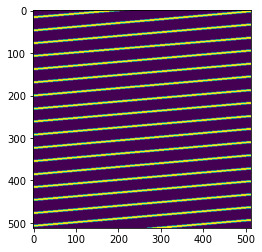

In [616]:
plt.imshow(mask_for_templates)

In [617]:
Intersection = np.nonzero((cell_mask!=0) & (mask_for_templates!=0))

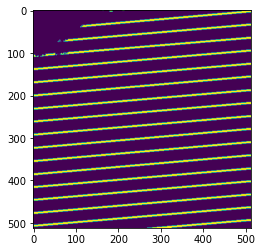

In [618]:
#plt.imshow(Intersection)

blank_array = np.zeros((512, 512))

blank_array[Intersection] = 1
plt.imshow(blank_array)

In [619]:
#import file which contains coordinates but also lots of other information
#AP2spots = pd.read_csv('/Volumes/GoogleDrive/My Drive/organized substrate movies/MDA_AP2GFP_cltaRFP/50nm/20191017/sicont/cell1_2s/All Spots statistics_AP2.csv')

#extract just the columns we want: x pos, y pos, total intensity
#xy_coords = AP2spots[["POSITION_X", "POSITION_Y", "TOTAL_INTENSITY"]]
xy_coords = puncta_csv[["POSITION_X", "POSITION_Y", "TOTAL_INTENSITY"]]

#create intermediate list of x coords and y coords
xcoords_list = []
ycoords_list = []
for i in puncta_csv["POSITION_X"]:
    xcoords_list.append(i/image_scale)

for j in puncta_csv["POSITION_Y"]:
    ycoords_list.append(j/image_scale)

#combine x and y coordinates into one list, create version of it compatible with analysis pipeline
combined_list = []
for i in range(0, len(xcoords_list)):
    entry = [xcoords_list[i], ycoords_list[i]]
    combined_list.append(entry)
punctafloats = [tuple(float(val) for val in sublist) for sublist in combined_list]


In [622]:
x_positions = [pos[0] for pos in punctafloats]
y_positions = [pos[1] for pos in punctafloats]

(array([ 3.,  6., 13., 21., 26., 29., 18., 14., 13.,  3.]),
 array([ 19.27536232,  66.91014493, 114.54492754, 162.17971014,
        209.81449275, 257.44927536, 305.08405797, 352.71884058,
        400.35362319, 447.9884058 , 495.62318841]),
 <a list of 10 Patch objects>)

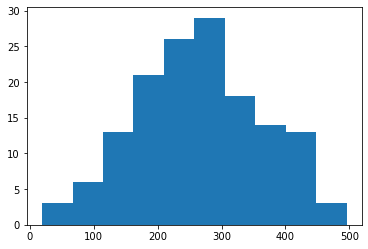

In [623]:
#sanity check for scaling, should extend to 512
plt.hist(y_positions)

In [624]:
nonzero_mask = np.nonzero(mask_for_templates)

In [625]:
x_pos = nonzero_mask[0]
y_pos = nonzero_mask[1]

differences = np.sqrt( np.square(x_pos-test_point[0]) + np.square(y_pos-test_point[1]))

In [626]:
#sanity check
differences[differences.argmin()]


15.565547995301477

In [627]:
def test_on_pillar_beta(puncta_coordinate,mask_positions,tolerance):
    """ Check if a puncta coordinate is on a mask pixel within a defined tolerance distance"""
    
    
    nonzero_mask_positions = np.nonzero(mask_positions)
    B = nonzero_mask_positions[0]
    A = nonzero_mask_positions[1]
    X = np.sqrt( np.square( A - puncta_coordinate[0] ) +  np.square( B - puncta_coordinate[1] ) )
    
    if len(np.where(X[X.argmin()]<tolerance)[0]):
        return 1
    else:
        return 0
#     idx = np.where( X == X.min() )
#     print(idx)
#     if (X[idx]<tolerance).any():
#         return 1
#     else:
#         return 0

The percentage of puncta on nanopillars predicted by TrackMate: 74.26470588235294


Text(0, 0.5, 'pixels')

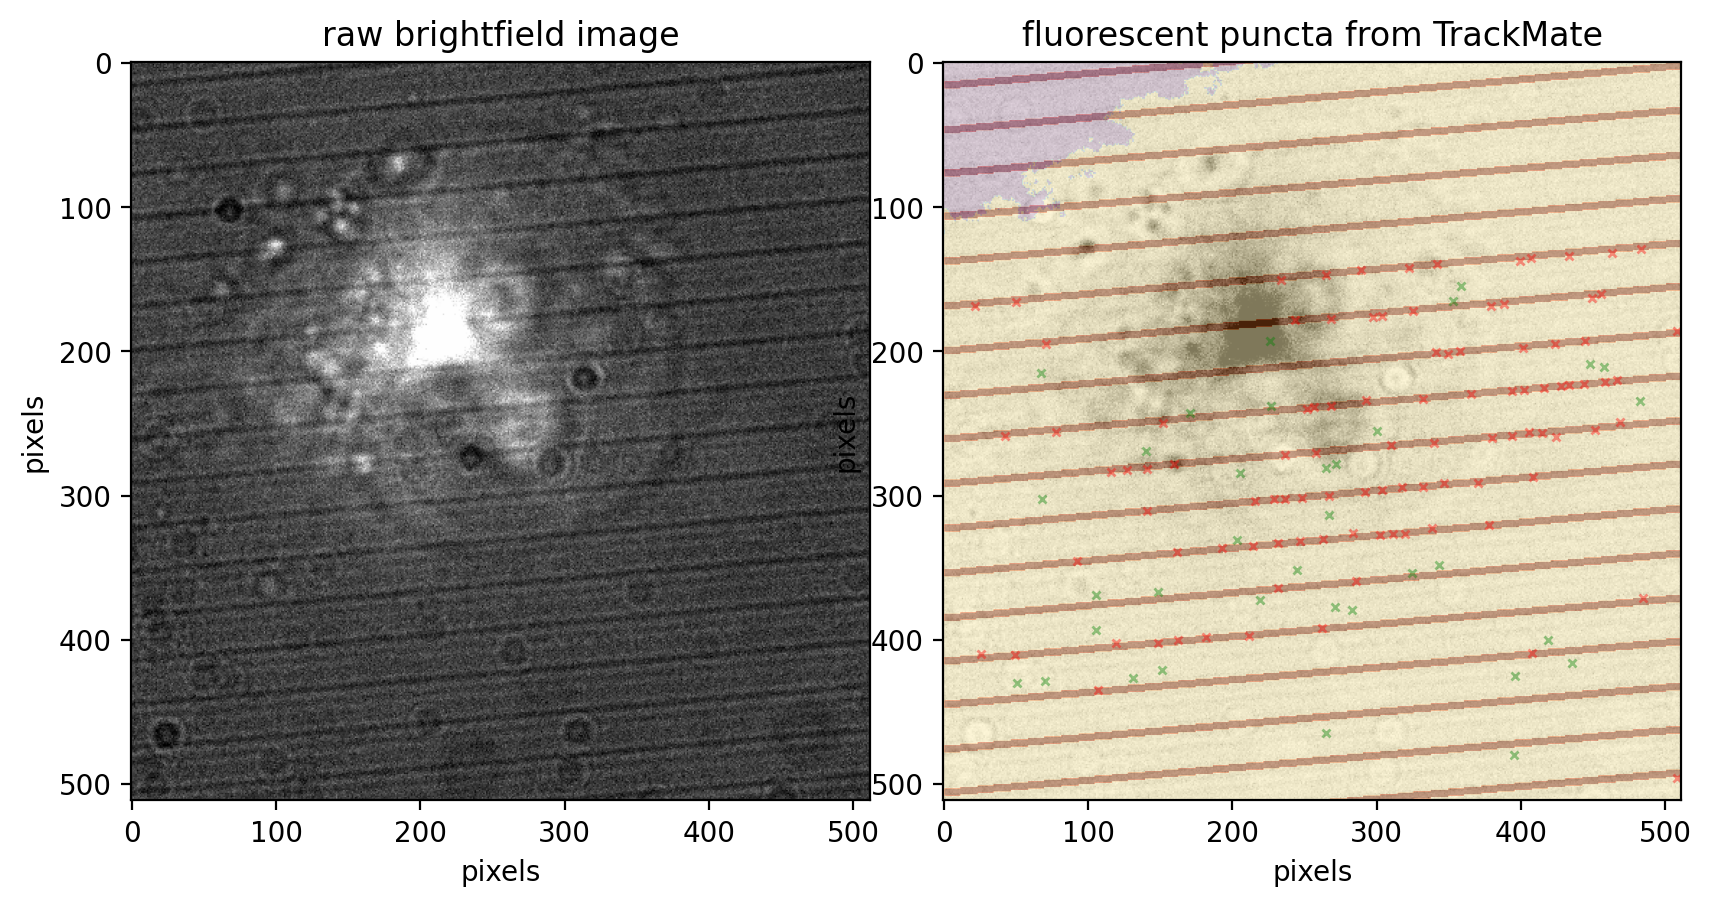

In [628]:
#### creating plots
from skimage.exposure import adjust_gamma
# intialize a 1x2 plot
f, axes = plt.subplots(1, 2, figsize=(10,5),gridspec_kw = {'wspace':0.1, 'hspace':0.1}, dpi=200)

####################################################################################################
####################################################################################################
# make_cell_profiler_overlay (bottom right)

# read TrackMate puncta
#if downshift isn't necessary, comment this line out:::::
#mask_for_templates = downshifted_mask

num_on_pillar = 0
num_off_pillar = 0

# load the fluorescent image (multi-chanel so itk works better than cv2)
fl_itk_image = load_itk_image(fl_image)

axes[1].imshow((mask_for_templates),cmap='Reds') # plot the mask
axes[1].imshow((cell_mask),alpha = 0.3)
axes[1].imshow(cv2.cvtColor(cv2.imread(bf_image),cv2.COLOR_BGR2GRAY),alpha=0.5,cmap='Greys') # plot the bright-field, first upload with imread(), then convert to greyscale with cvtColor()
axes[0].imshow(adjust_gamma(cv2.imread(bf_image),gamma = 0.01), cmap='Reds',alpha=1) # show the fluorescent channel
# test whether each puncta is on or off the list
for pair in punctafloats:
    if pair[1]>120:
        on_pillar = test_on_pillar_beta([int(pair[0]), int(pair[1])],mask_for_templates,2) # pass in each pair of (x,y), the mask, and a distance (by pixel length) tolerance for points away from the mask [mask is integers, puncta are floats]
    #     print(pair)
        if on_pillar==1:
            num_on_pillar+=1
            axes[1].plot(pair[0],pair[1],marker='x',markerSize=3,color='r', alpha=0.4, linewidth=1)
        else:
            num_off_pillar+=1
            axes[1].plot(pair[0],pair[1],marker='x',markerSize=3,color='g', alpha=0.4, linewidth=1)
axes[1].set_title('fluorescent puncta from TrackMate')
axes[1].set_xlabel('pixels')
axes[1].set_ylabel('pixels')

percentage_on_pillar_cell_profiler = num_on_pillar/(num_on_pillar+num_off_pillar)*100
print('The percentage of puncta on nanopillars predicted by TrackMate: ' + str(percentage_on_pillar_cell_profiler))

# take the bottom right plot, zoom in by 2.5, put in 3rd quadrant
# add insent later
#axins = zoomed_inset_axes(axes[1], 2.5, loc=3) 


####################################################################################################
####################################################################################################




####################################################################################################
####################################################################################################
# make raw image
axes[0].imshow(cv2.imread(bf_image),alpha=1,cmap='Blues')
axes[0].set_title('raw brightfield image')
axes[0].set_xlabel('pixels')
axes[0].set_ylabel('pixels')
####################################################################################################
####################################################################################################


#plt.savefig('photos_of_nanopillar_figures/sample_for_bob.png',dpi=500)

In [629]:
## percent of cell that is "on-mask"
mask_area = len(np.where(blank_array==True)[0])*(len(np.where(cell_mask==True)[0])/(512*512))/(512*512)

0.14897116413339972

In [113]:
#corrections: 1.085 for 75nm,
# 1.18 for 120nm
# 1.25 for 200nm
# 1.33 for 300nm
# 1.34 for 500nm
corrected_mask_area = mask_area * 1.085

0.29177581614931114

In [ ]:
##calculate enrichment here:
74.3/corrected_mask_area